# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import os

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [34]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))#, download=True)
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))#, download=True)

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [3]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [4]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [5]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [6]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    
    for epoch in range(num_epochs): 
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
            
        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    correct_samples = 0
    total_samples = 0
    for (x, y) in loader:
        prediction = model(x)    

        indices = torch.argmax(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]
    
    val_accuracy = float(correct_samples) / total_samples
    return val_accuracy

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.828681, Train accuracy: 0.401990, Val accuracy: 0.544673
Average loss: 1.460470, Train accuracy: 0.582005, Val accuracy: 0.600846
Average loss: 1.380581, Train accuracy: 0.616183, Val accuracy: 0.616204


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [7]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10),
       )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.172261, Train accuracy: 0.210303, Val accuracy: 0.251587
Average loss: 1.948708, Train accuracy: 0.303706, Val accuracy: 0.378404
Average loss: 1.748935, Train accuracy: 0.405027, Val accuracy: 0.418128
Average loss: 1.688650, Train accuracy: 0.432004, Val accuracy: 0.431302
Average loss: 1.671196, Train accuracy: 0.442088, Val accuracy: 0.434100


Добавьте слой с Batch Normalization

In [8]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10),
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.082733, Train accuracy: 0.302034, Val accuracy: 0.443383
Average loss: 1.761561, Train accuracy: 0.478364, Val accuracy: 0.519828
Average loss: 1.629910, Train accuracy: 0.542061, Val accuracy: 0.568357
Average loss: 1.547135, Train accuracy: 0.579787, Val accuracy: 0.586922
Average loss: 1.492891, Train accuracy: 0.600263, Val accuracy: 0.618115


Добавьте уменьшение скорости обучения по ходу тренировки.

In [12]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 10),
         )

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)  # add sheduler
    for epoch in range(num_epochs):
        model.train() # Enter train mode

        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
        
        scheduler.step()  # use the sheduler
        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        #scheduler.step()  # use the sheduler
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history


optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.773022, Train accuracy: 0.446746, Val accuracy: 0.517507
Average loss: 1.616550, Train accuracy: 0.546036, Val accuracy: 0.556003
Average loss: 1.597319, Train accuracy: 0.577978, Val accuracy: 0.591632
Average loss: 1.617131, Train accuracy: 0.564993, Val accuracy: 0.545697
Average loss: 1.583740, Train accuracy: 0.588250, Val accuracy: 0.571838


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [15]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    sampler = SubsetSampler(indices)
    batch_size = 64
    
    predictions, ground_truth = [], []
    
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=sampler)
    for (x, y) in loader:
        predict = model(x)        
        indices = torch.argmax(predict, 1)
        
        predictions.extend(list(indices.numpy()))
        ground_truth.extend(list(y.numpy()))
        
    predictions = np.array(predictions)
    ground_truth = np.array(ground_truth)

    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

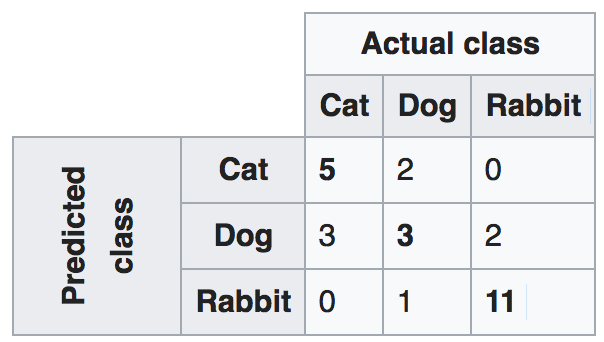

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

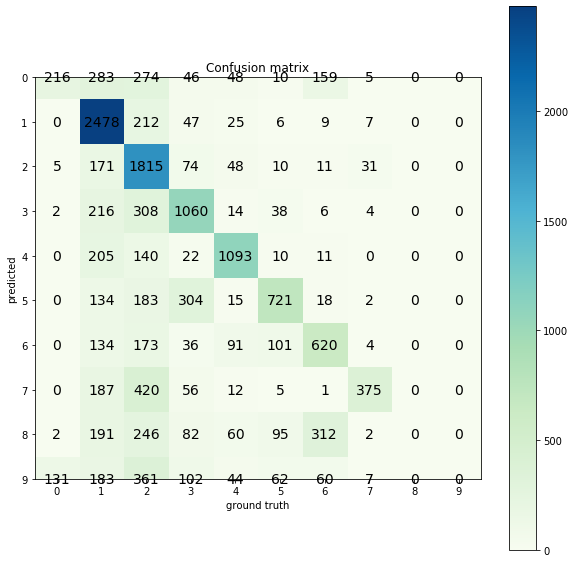

In [20]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
          

    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), np.int)
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            confusion_matrix[i][j] = np.sum(predictions[ground_truth == i] == j)
    
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

In [46]:
from pandas.plotting import register_matplotlib_converters
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    register_matplotlib_converters()
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, ground_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    
    title = f"Visualize: predicted_class is {predicted_class}, gt_class is {gt_class}"
    indices = val_indices[(ground_truth == gt_class) & (predictions == predicted_class)]
    
    visualize_images(indices, data, title, max_num=10)

#visualize_predicted_actual(7, 2, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(8, 6, predictions, gt, np.array(val_indices), data_train_images)

<Figure size 720x108 with 0 Axes>

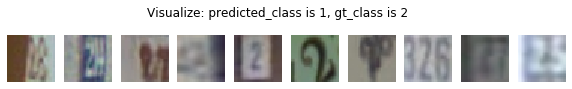

In [45]:
visualize_predicted_actual(1, 2, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [48]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler):    
    loss_history = []
    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        model.train() # Enter train mode

        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
            
        if scheduler:
            scheduler.step()  # use the sheduler
        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        #scheduler.step()  # use the sheduler
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    correct_samples = 0
    total_samples = 0
    for (x, y) in loader:
        prediction = model(x)    

        indices = torch.argmax(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]
    
    val_accuracy = float(correct_samples) / total_samples
    return val_accuracy

def loss_accuracy_plot(loss_history, train_history, val_history):
    plt.figure(figsize=(10, 7))
    plt.subplot(211)
    plt.title("Loss")
    plt.plot(loss_history)
    plt.subplot(212)
    plt.title("Train/validation accuracy")
    plt.plot(train_history, label="train")
    plt.plot(val_history, label="validation")
    plt.legend();

In [55]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 10),
         )

#optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
optimizer = optim.Adam(nn_model.parameters(), lr=1e-5, weight_decay=1e-1)
#scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 30, scheduler=None)

Average loss: 2.137823, Train accuracy: 0.265570, Val accuracy: 0.439833
Average loss: 1.795464, Train accuracy: 0.505272, Val accuracy: 0.571292
Average loss: 1.611523, Train accuracy: 0.582995, Val accuracy: 0.620913
Average loss: 1.494664, Train accuracy: 0.624253, Val accuracy: 0.652652
Average loss: 1.401302, Train accuracy: 0.651537, Val accuracy: 0.677565
Average loss: 1.321532, Train accuracy: 0.672815, Val accuracy: 0.691966
Average loss: 1.253242, Train accuracy: 0.689946, Val accuracy: 0.706914
Average loss: 1.193991, Train accuracy: 0.703904, Val accuracy: 0.714286
Average loss: 1.142049, Train accuracy: 0.715370, Val accuracy: 0.730735
Average loss: 1.100117, Train accuracy: 0.726410, Val accuracy: 0.732168
Average loss: 1.063179, Train accuracy: 0.734413, Val accuracy: 0.741656
Average loss: 1.028107, Train accuracy: 0.744787, Val accuracy: 0.747389
Average loss: 1.000120, Train accuracy: 0.750316, Val accuracy: 0.756604
Average loss: 0.974433, Train accuracy: 0.758540, V

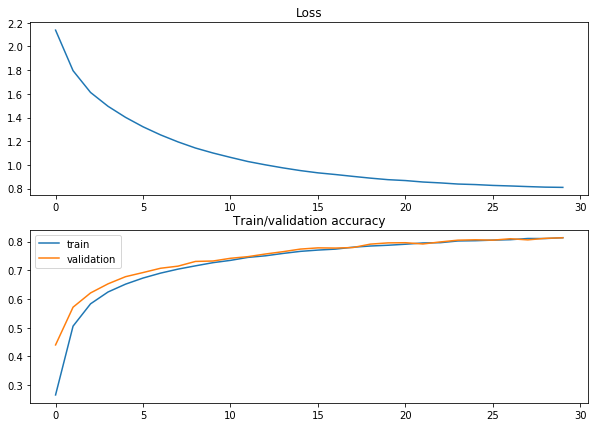

In [56]:
loss_accuracy_plot(loss_history, train_history, val_history)

In [57]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.7984


In [58]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True),
            nn.Linear(100, 200), 
            nn.BatchNorm1d(200), 
            nn.ReLU(inplace=True),
            nn.Linear(200, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 10),
         )

#optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
optimizer = optim.Adam(nn_model.parameters(), lr=1e-5, weight_decay=1e-1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) 
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 40, scheduler)

Average loss: 2.172913, Train accuracy: 0.233969, Val accuracy: 0.428230
Average loss: 1.756334, Train accuracy: 0.505716, Val accuracy: 0.579892
Average loss: 1.516799, Train accuracy: 0.602754, Val accuracy: 0.645963
Average loss: 1.364381, Train accuracy: 0.648722, Val accuracy: 0.678657
Average loss: 1.252417, Train accuracy: 0.679026, Val accuracy: 0.709235
Average loss: 1.161049, Train accuracy: 0.701856, Val accuracy: 0.722203
Average loss: 1.089371, Train accuracy: 0.717486, Val accuracy: 0.735718
Average loss: 1.032092, Train accuracy: 0.731427, Val accuracy: 0.746092
Average loss: 0.980112, Train accuracy: 0.745743, Val accuracy: 0.757013
Average loss: 0.939653, Train accuracy: 0.754684, Val accuracy: 0.764316
Average loss: 0.896378, Train accuracy: 0.769205, Val accuracy: 0.773258
Average loss: 0.880273, Train accuracy: 0.772856, Val accuracy: 0.776944
Average loss: 0.862967, Train accuracy: 0.777685, Val accuracy: 0.780152
Average loss: 0.847557, Train accuracy: 0.781558, V

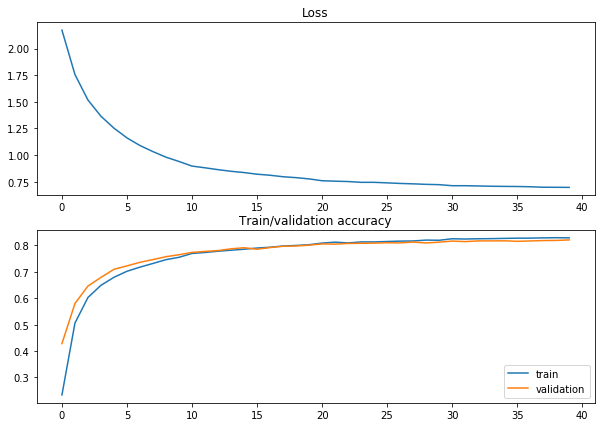

In [59]:
loss_accuracy_plot(loss_history, train_history, val_history)

In [60]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8025
